In [1]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.layers import Input,  GRU, LSTM, Dense, Dropout, Add
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf
import itertools

import warnings
warnings.filterwarnings("ignore")

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

In [72]:
jj = pd.read_csv('jj.csv')

In [73]:
jj.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


# JJ

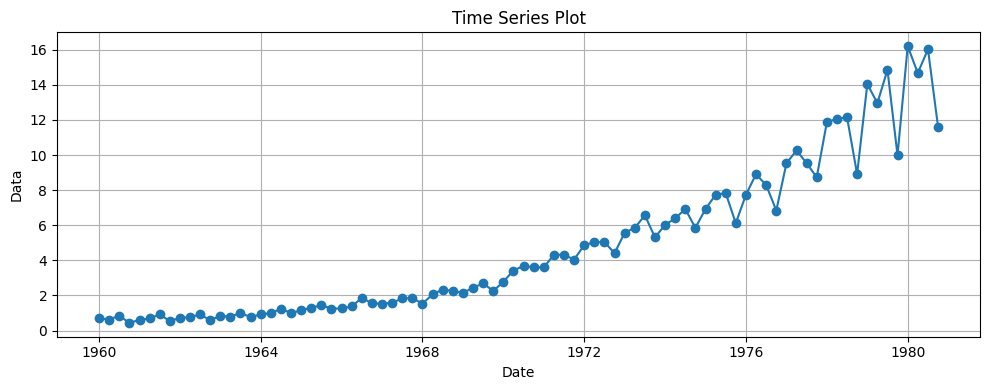

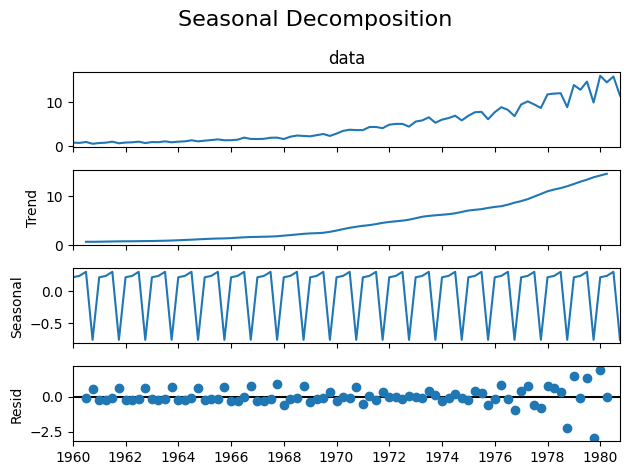

In [79]:
jj['date'] = pd.to_datetime(jj['date'])
jj.set_index('date', inplace=True)

plt.figure(figsize=(10, 4))
plt.plot(jj, marker='o')
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Data")
plt.grid(True)
plt.tight_layout()
plt.show()

decomposition = seasonal_decompose(jj['data'], model='additive', period=4)

decomposition.plot()
plt.suptitle("Seasonal Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
adf_result = adfuller(jj['data'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: 2.742016573457473
p-value: 1.0


In [7]:
jj_diff = jj.diff().dropna()

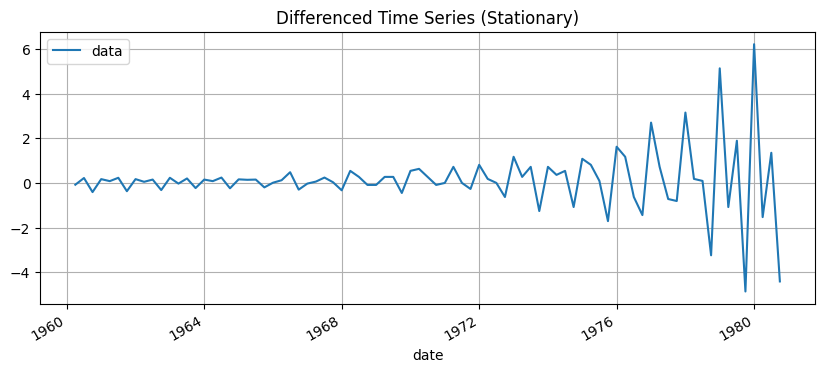

In [8]:
jj_diff.plot(figsize=(10, 4), title="Differenced Time Series (Stationary)")
plt.grid(True)
plt.show()

Best ARIMA order: (4, 1, 1)
Train MSE: 0.1701
Test MSE: 1.0281


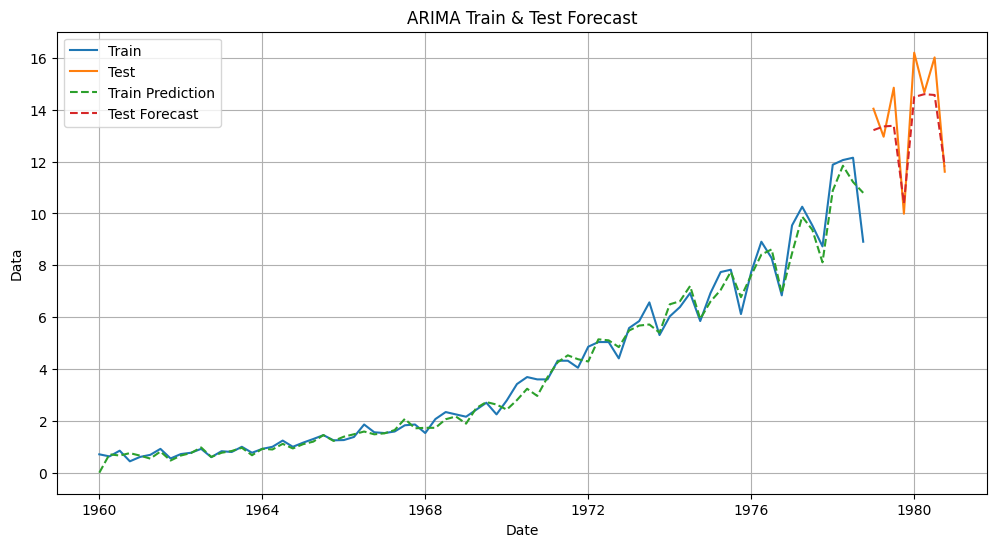

In [9]:
jj = pd.read_csv('jj.csv')

jj['date'] = pd.to_datetime(jj['date'])
jj.set_index('date', inplace=True)

train = jj.iloc[:-8]
test = jj.iloc[-8:]

model = auto_arima(train['data'],
                   seasonal=True,
                   stepwise=True,
                   suppress_warnings=True,
                   error_action='ignore',
                   max_p=5, max_q=5,
                   max_d=5,
                   information_criterion='aic')

print("Best ARIMA order:", model.order)

train_pred = model.predict_in_sample()

test_pred = model.predict(n_periods=len(test))

train_mse = mean_squared_error(train['data'], train_pred)
test_mse = mean_squared_error(test['data'], test_pred)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['data'], label='Train')
plt.plot(test.index, test['data'], label='Test')
plt.plot(train.index, train_pred, label='Train Prediction', linestyle='--')
plt.plot(test.index, test_pred, label='Test Forecast', linestyle='--')
plt.title('ARIMA Train & Test Forecast')
plt.xlabel('Date')
plt.ylabel('Data')
plt.legend()
plt.grid(True)
plt.show()


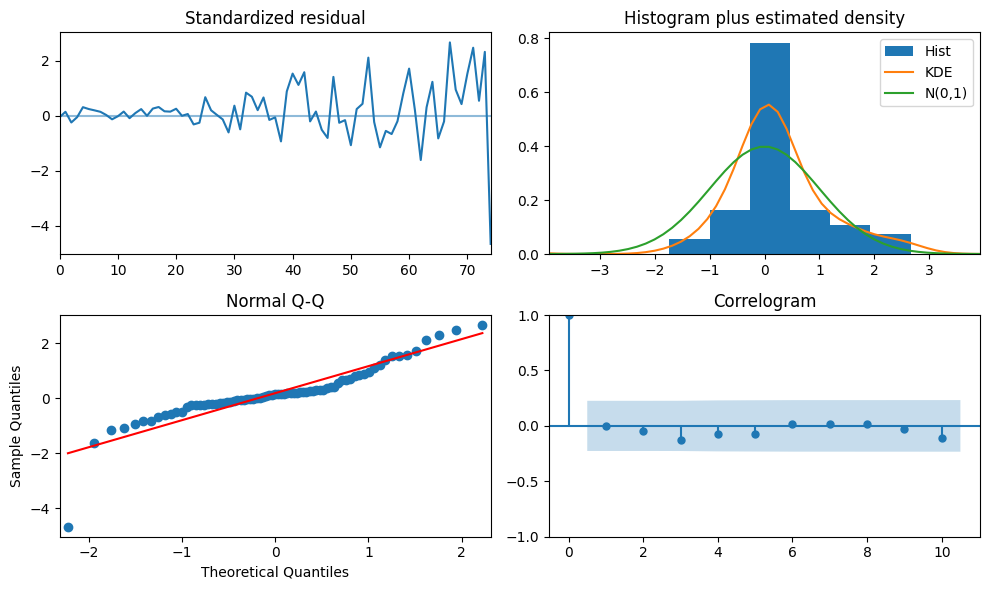

In [10]:
model.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()
plt.show()

In [11]:
n_periods = 24
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

In [12]:
last_date = jj.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.DateOffset(months=3),
                               periods=n_periods, freq='MS')


In [13]:
forecast_df = pd.DataFrame({'forecast': forecast})#, index=forecast_index)
forecast_df.index = forecast_index

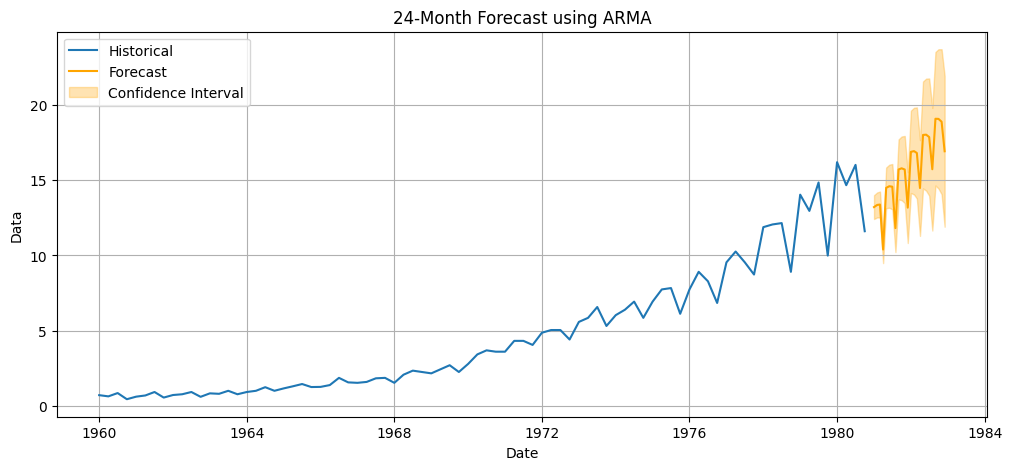

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(jj, label='Historical')
plt.plot(forecast_df, label='Forecast', color='orange')
plt.fill_between(forecast_index,
                 conf_int[:, 0], conf_int[:, 1],
                 color='orange', alpha=0.3, label='Confidence Interval')
plt.title("24-Month Forecast using ARMA")
plt.xlabel("Date")
plt.ylabel("Data")
plt.legend()
plt.grid(True)
plt.show()

In [98]:
jj = pd.read_csv('jj.csv')
jj['date'] = pd.to_datetime(jj['date'])
jj.set_index('date', inplace=True)

train = jj.iloc[:-8]  
test = jj.iloc[-8:]   

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

deep_lstm_model = Sequential([
    LSTM(16, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.3),
    
    LSTM(32),
    Dropout(0.3),
    
    Dense(16, activation='relu'),
    Dense(1)
])

deep_lstm_model.compile(optimizer=Adam(0.001), loss='mse')
deep_lstm_model.fit(X_train, y_train, epochs=200, verbose=0)


In [99]:
deep_lstm_forecast = forecast_future(deep_lstm_model, last_seq, 24, scaler)

deep_lstm_pred = deep_lstm_forecast[:8]
mse = mean_squared_error(test, deep_lstm_pred)
mae = mean_absolute_error(test, deep_lstm_pred)

print("Deep Stacked LSTM Forecast:")
print("MSE:", mse)
print("MAE:", mae)


Deep Stacked LSTM Forecast:
MSE: 11.654026985168457
MAE: 2.9125654697418213


In [106]:
last_date = jj.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.DateOffset(months=3),
                               periods=n_periods, freq='MS')

forecast_df = pd.DataFrame({'forecast': deep_lstm_forecast})
forecast_df.index = forecast_index

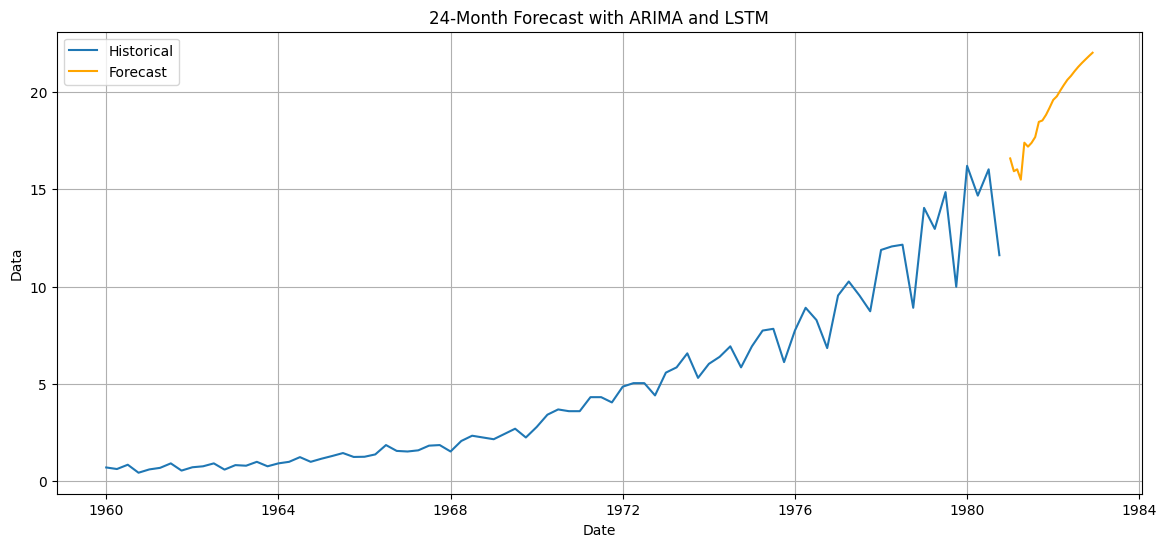

In [108]:
plt.figure(figsize=(14, 6))
plt.plot(jj, label='Historical')
plt.plot(forecast_df.index,forecast_df, label='Forecast', color='orange')
plt.title('24-Month Forecast with LSTM')
plt.xlabel('Date')
plt.ylabel('Data')
plt.legend()
plt.grid(True)
plt.show()

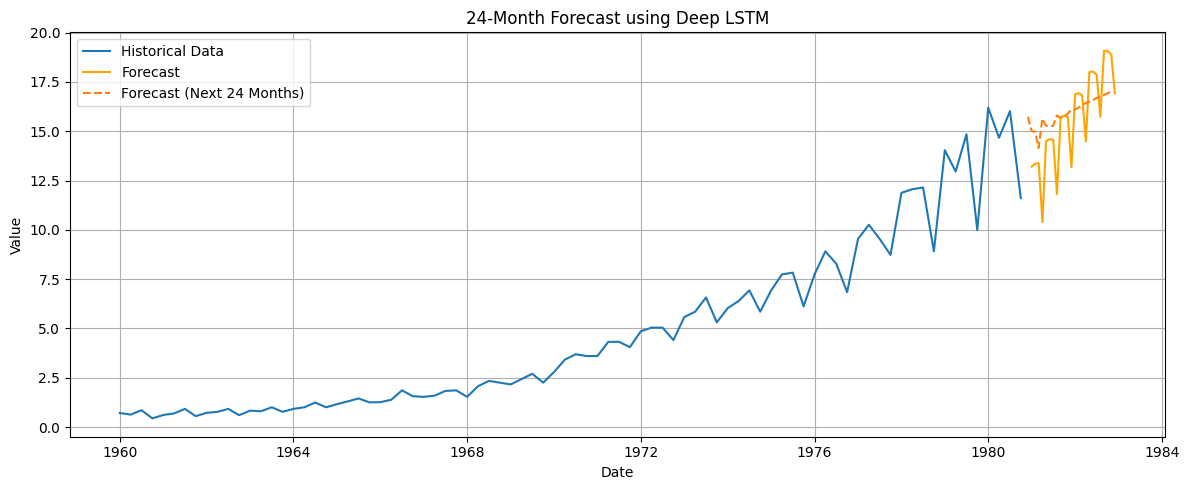

In [20]:
last_seq = scaled_data[-window_size:]
deep_lstm_forecast_24 = forecast_future(deep_lstm_model, last_seq, 24, scaler)

last_date = jj.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='M')

plt.figure(figsize=(12, 5))
plt.plot(jj.index, jj['data'], label='Historical Data')
plt.plot(forecast_df, label='Forecast', color='orange')
plt.plot(future_dates, deep_lstm_forecast_24, label='Forecast (Next 24 Months)', linestyle='--')
plt.title('24-Month Forecast using Deep LSTM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Amazon

In [44]:
import pmdarima as pm

In [45]:
amazon = pd.read_csv('AMZN.csv')

In [46]:
amazon.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
1,2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2,2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
3,2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
4,2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


In [47]:
amazon['Date'] = pd.to_datetime(amazon['Date'])
amazon.set_index('Date', inplace=True)
ts = amazon['Adj Close']

In [48]:
ts = ts.resample('W').mean()

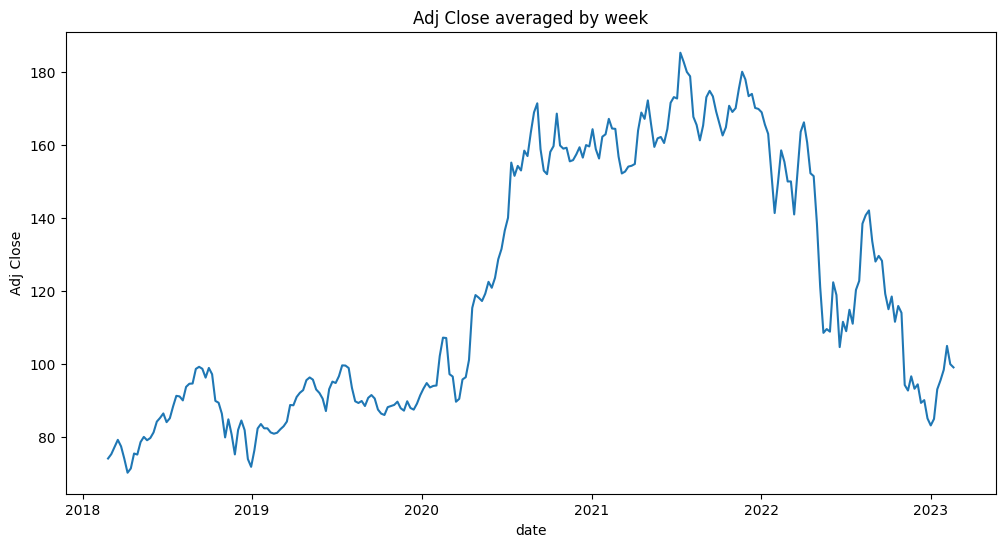

In [69]:
plt.figure(figsize=(12,6))
plt.plot(ts)
plt.xlabel('date')
plt.ylabel('Adj Close')
plt.title('Adj Close averaged by week')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1417.293, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1422.801, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1415.738, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1415.780, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1421.316, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1417.421, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1417.586, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1416.858, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1414.070, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1415.785, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1415.932, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1414.149, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1415.438, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.516 seconds


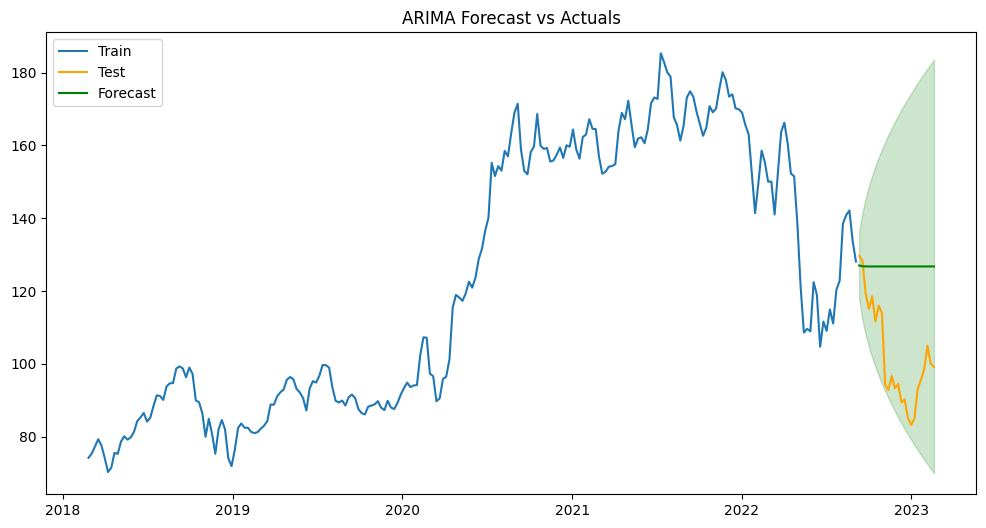

Mean Squared Error Train: 46.1691
Mean Squared Error Test: 790.6885


In [113]:
test_size = 24

train = ts[:-test_size]
test = ts[-test_size:]

model = pm.auto_arima(train, seasonal=False, stepwise=True, 
                      suppress_warnings=True, error_action="ignore", trace=True)

in_sample_pred = model.predict_in_sample()
train_mse = mean_squared_error(train, in_sample_pred)

forecast, conf_int = model.predict(n_periods=test_size, return_conf_int=True)

forecast_index = test.index  

forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower CI': conf_int[:, 0],
    'Upper CI': conf_int[:, 1]
}, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(forecast_index, forecast, label='Forecast', color='green')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2)
plt.legend()
plt.title('ARIMA Forecast vs Actuals')
plt.show()

mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error Train: {train_mse:.4f}")
print(f"Mean Squared Error Test: {mse:.4f}")


In [114]:
forecast_series = pd.Series(forecast)
forecast_series.index = forecast_index

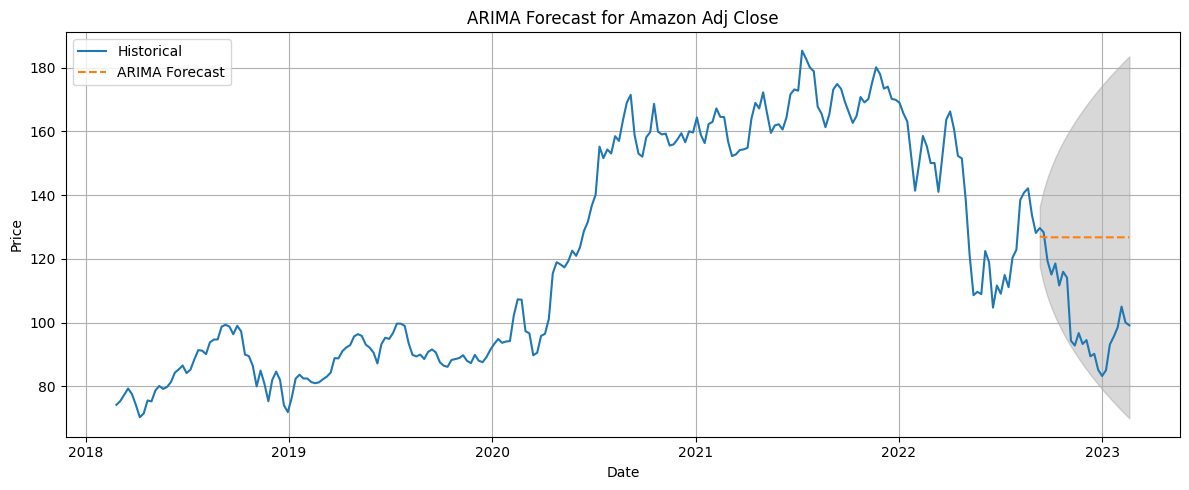

In [115]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Historical')
plt.plot(forecast_series, label='ARIMA Forecast', linestyle='--')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.3)
plt.title("ARIMA Forecast for Amazon Adj Close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [116]:
ts = amazon['Adj Close'].asfreq('B').fillna(method='ffill') 

scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))

In [117]:
train_size = int(len(scaled_ts) * 0.9)
train_data = scaled_ts[:train_size]
test_data = scaled_ts[train_size:]


In [118]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 30 
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)


In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)


In [127]:
predictions = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predictions)
true_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


In [128]:
ts = amazon['Adj Close'].asfreq('B').fillna(method='ffill') 

scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))

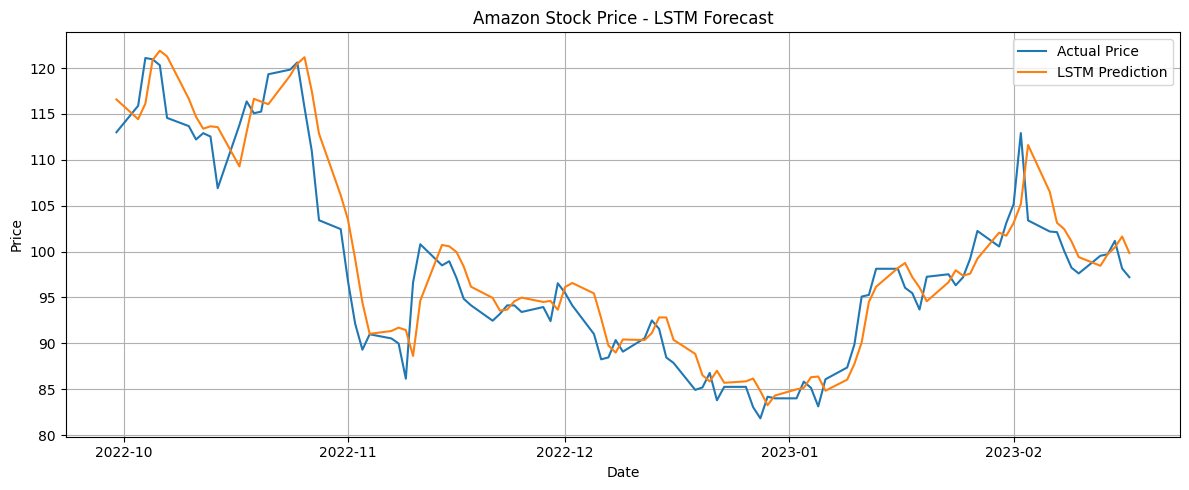

In [129]:
import matplotlib.pyplot as plt

test_dates = ts.index[train_size + window_size:]

plt.figure(figsize=(12, 5))
plt.plot(test_dates, true_prices, label='Actual Price')
plt.plot(test_dates, predicted_prices, label='LSTM Prediction')
plt.title('Amazon Stock Price - LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [130]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(true_prices, predicted_prices)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 10.789252456964471


In [131]:
last_sequence = X_test[-1] 
n_steps = 24

future_predictions = []
current_input = last_sequence.copy()

for _ in range(n_steps):
    pred = model.predict(current_input[np.newaxis, :, :], verbose=0)[0]
    future_predictions.append(pred[0])
    current_input = np.roll(current_input, -1)  
    current_input[-1] = pred  

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

last_date = ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=24, freq='B') 

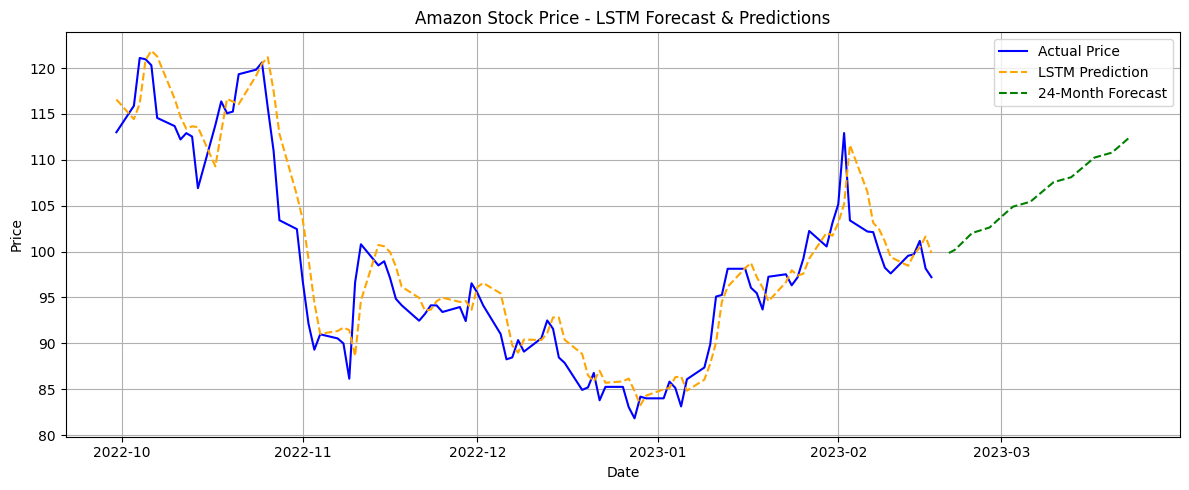

In [132]:
plt.figure(figsize=(12, 5))
plt.plot(ts.index[train_size + window_size:], true_prices, label='Actual Price', color='blue')
plt.plot(ts.index[train_size + window_size:], predicted_prices, label='LSTM Prediction', linestyle='--', color='orange')
plt.plot(future_dates, future_predictions, label='24-Month Forecast', linestyle='--', color='green')
plt.title('Amazon Stock Price - LSTM Forecast & Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
